In [12]:
import itertools, copy, numpy as np, pandas as pd, matplotlib.pyplot as plt, statsmodels.api as sm, seaborn as sns
# from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from datetime import timedelta
from scipy import stats
from matplotlib import font_manager, rc
from sklearn.model_selection import TimeSeriesSplit

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
#read csv
train_df = pd.read_csv("""G:/.shortcut-targets-by-id/1G_BvRDrPHUUlK2PI39jxm4eDd8jjWATF/k-water/data_city/data_tr_city.csv""")
test_df = pd.read_csv("""G:/.shortcut-targets-by-id/1G_BvRDrPHUUlK2PI39jxm4eDd8jjWATF/k-water/data_city/data_ts_city.csv""")

In [13]:
# string to datetime
if 'datetime' in train_df.columns: train_df['datetime'] = pd.to_datetime(train_df['datetime'])
if 'datetime' in test_df.columns: test_df['datetime'] = pd.to_datetime(test_df['datetime'])

In [14]:
#Exploratory Data Analysis
if train_df.index.dtype == 'int64': train_df.set_index('datetime', inplace=True)
if test_df.index.dtype == 'int64': test_df.set_index('datetime', inplace=True)
#preprocessing Mussing Value and Outlier
for idx in train_df['구미 혁신도시배수지 유출유량 적산차'].index:
    if(train_df.at[idx,'구미 혁신도시배수지 유출유량 적산차'] <0.0):
        o_h_a= idx- timedelta(hours=1)
        o_h_l  = idx + timedelta(hours=1)
        train_df.at[idx,'구미 혁신도시배수지 유출유량 적산차'] = np.mean((train_df.at[o_h_a, 
            '구미 혁신도시배수지 유출유량 적산차'],
            train_df.at[o_h_l, '구미 혁신도시배수지 유출유량 적산차']))
    if 2000.0< train_df.at[idx,'구미 혁신도시배수지 유출유량 적산차']:
        h=1
        while np.isnan(train_df.at[idx + timedelta(hours=h),'구미 혁신도시배수지 유출유량 적산차']): h+=1
        train_df.at[idx,'구미 혁신도시배수지 유출유량 적산차'] = np.mean((train_df.at[idx- timedelta(hours=1), 
            '구미 혁신도시배수지 유출유량 적산차'],
            train_df.at[idx + timedelta(hours=h), '구미 혁신도시배수지 유출유량 적산차']))
#replace1 mv(age)
for idx in train_df['구미 혁신도시배수지 유출유량 적산차'].index:
    if np.isnan(train_df.at[idx,'구미 혁신도시배수지 유출유량 적산차']): 
        h=1
        while np.isnan(train_df.at[idx + timedelta(hours=h),'구미 혁신도시배수지 유출유량 적산차']): h+=1
        train_df.at[idx,'구미 혁신도시배수지 유출유량 적산차'] = np.mean((train_df.at[idx- timedelta(hours=1), 
            '구미 혁신도시배수지 유출유량 적산차'],
            train_df.at[idx + timedelta(hours=h), '구미 혁신도시배수지 유출유량 적산차']))
# replace 0f
train_df =train_df.replace(0,0.000000001)                        
test_df =test_df.replace(0,0.000000001)

Skewness 0.636156
Kurtosis 0.151112
Skewness -1.286794
Kurtosis 2.225577


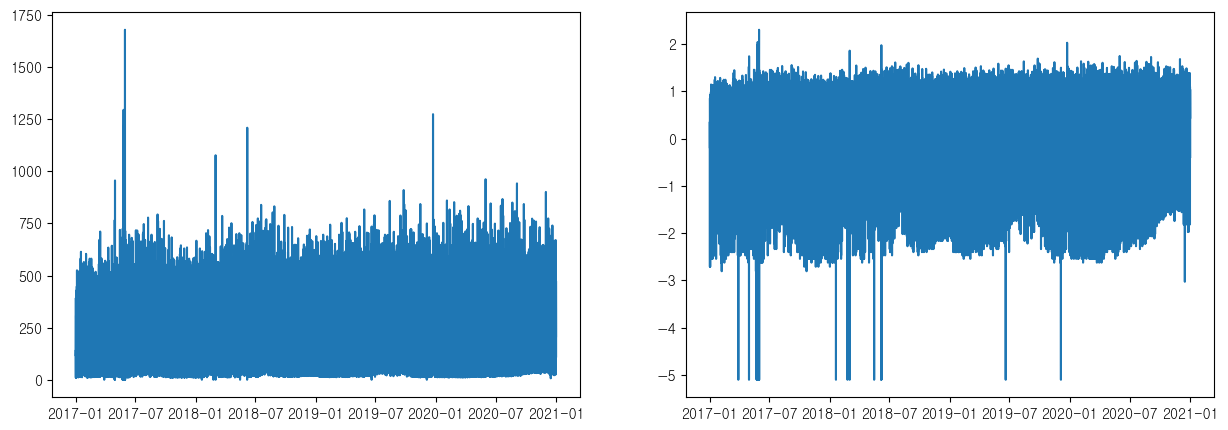

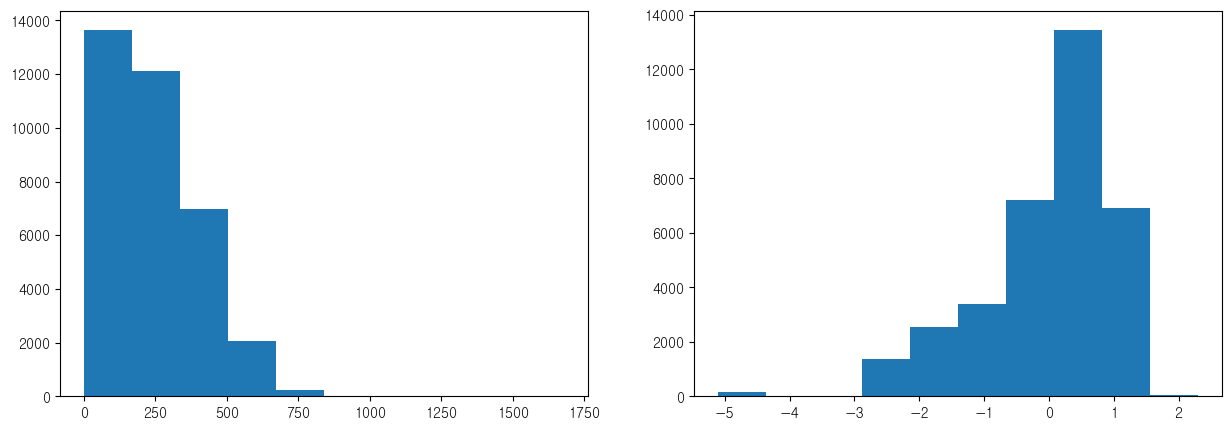

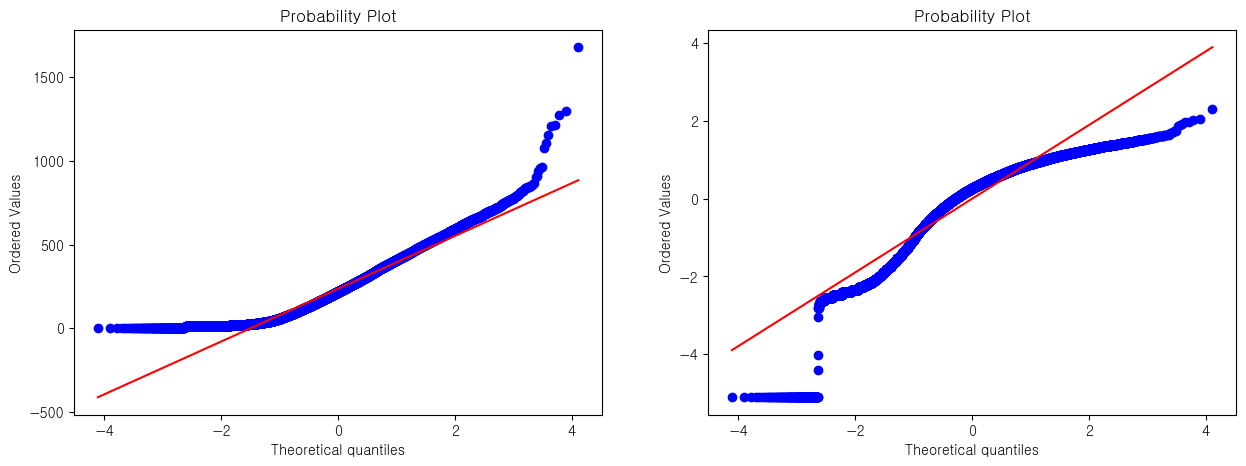

In [15]:
from sklearn.preprocessing import StandardScaler
train_df.describe(include='all').T
print("Skewness %f" % train_df['구미 혁신도시배수지 유출유량 적산차'].skew())
print("Kurtosis %f" % train_df['구미 혁신도시배수지 유출유량 적산차'].kurt())
fig = plt.figure(figsize = (15,5))
fig3 = plt.figure(figsize = (15,5))
fig2 = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_df)
ax3 = fig3.add_subplot(1, 2, 1)
ax3.hist(train_df)
ax11 = fig2.add_subplot(1, 2, 1)
ax11 = stats.probplot(train_df['구미 혁신도시배수지 유출유량 적산차'], plot=plt)
#scaler
train_df['구미 혁신도시배수지 유출유량 적산차'] = np.log1p(train_df['구미 혁신도시배수지 유출유량 적산차'])
test_df['구미 혁신도시배수지 유출유량 적산차'] = np.log1p(test_df['구미 혁신도시배수지 유출유량 적산차'])
scaler =StandardScaler()
train_df['구미 혁신도시배수지 유출유량 적산차'] = scaler.fit_transform(train_df)
test_df['구미 혁신도시배수지 유출유량 적산차'] =  scaler.transform(test_df)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_df)
ax4 = fig3.add_subplot(1, 2, 2)
ax4.hist(train_df)
ax12 = fig2.add_subplot(1, 2, 2)
ax12 = stats.probplot(train_df['구미 혁신도시배수지 유출유량 적산차'], plot=plt)
print("Skewness %f" % train_df['구미 혁신도시배수지 유출유량 적산차'].skew())
print("Kurtosis %f" % train_df['구미 혁신도시배수지 유출유량 적산차'].kurt())
# histogram plot
plt.show()

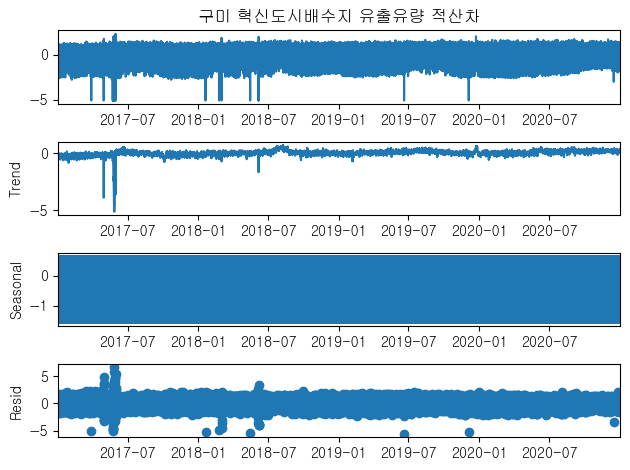

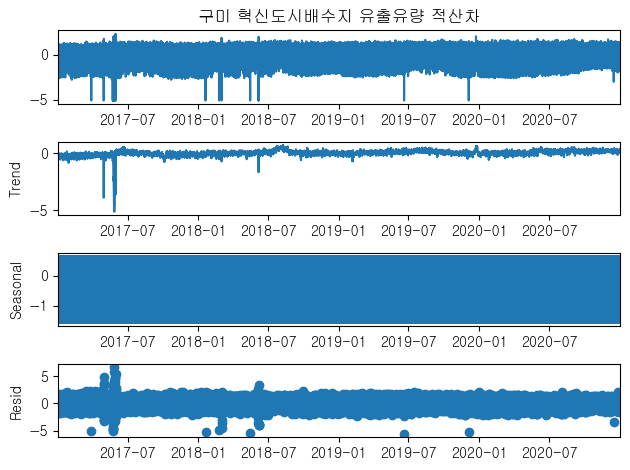

In [16]:
sm.tsa.seasonal_decompose(train_df['구미 혁신도시배수지 유출유량 적산차'], model='additive').plot()

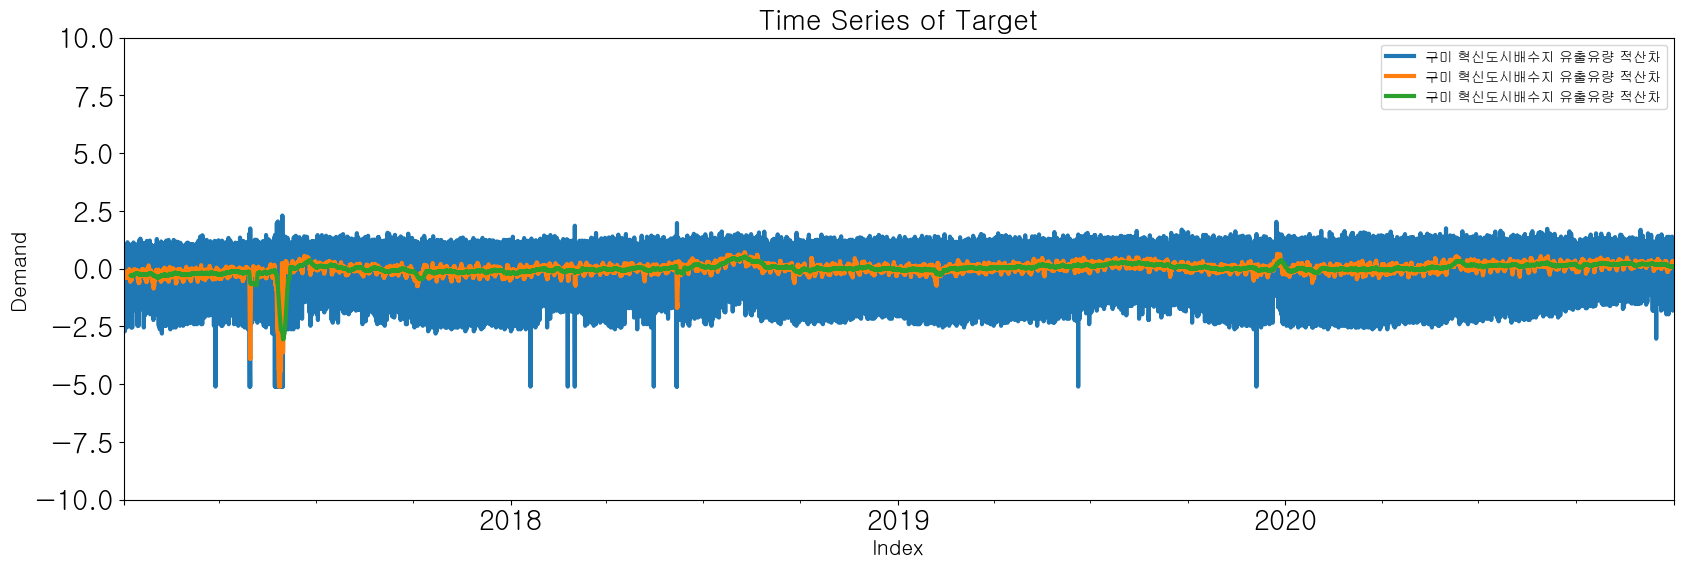

In [17]:
pd.concat([train_df[['구미 혁신도시배수지 유출유량 적산차']],
           train_df[['구미 혁신도시배수지 유출유량 적산차']].rolling(24).mean(),
           train_df[['구미 혁신도시배수지 유출유량 적산차']].rolling(24*7).mean()], axis=1).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                                                  ylim=(-10,10))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)         
plt.show()

In [18]:
hour = train_df['구미 혁신도시배수지 유출유량 적산차'].to_period("H")
hour_ts = test_df['구미 혁신도시배수지 유출유량 적산차'].to_period("H")
st =24*7*2*4 # 임시
# hour = hour[25000:35063]

In [19]:
train_df

,구미 혁신도시배수지 유출유량 적산차
datetime,
2017-01-01 01:00:00,-0.183281
2017-01-01 02:00:00,0.353227
2017-01-01 03:00:00,-0.257764
2017-01-01 04:00:00,-2.404373
2017-01-01 05:00:00,-2.626982
...,...
2020-12-31 19:00:00,0.676239
2020-12-31 20:00:00,0.732249
2020-12-31 21:00:00,0.697242


In [20]:
from statsmodels.tsa.vector_ar.var_model import VAR
# from statsmodels.tsa.stattools import adfuller # 이거에 관련해서 공부 필요
train_df['lag1'] = train_df['구미 혁신도시배수지 유출유량 적산차'].shift(1)
train_df['lag2'] = train_df['구미 혁신도시배수지 유출유량 적산차'].shift(2)
train_df['lag1'].fillna(method='bfill', inplace=True)
train_df['lag2'].fillna(method='bfill', inplace=True)
# 윗부분 아까 학원가서 붙이기
# train_lag = sm.add_constant(train_df.iloc[:,1:3])
# train_lag_add = train_lag.iloc[:,1:3]
train_lag = train_df.iloc[:,1:3]

forecasting_model = VAR(train_lag)
results_aic = []
# with tqdm(range(10)) as pg:
#   for p in pg:
#     pg.update(1)
#     try:
#       results = forecasting_model.fit(p)
#       results_aic.append(results.aic)
#     except:
#         continue
# for p in range(1,100):
#   results = forecasting_model.fit(p)
#   results_aic.append(results.aic)
# results_aic
# sns.set()
# plt.plot(list(np.arange(1,100,1)), results_aic)
# plt.xlabel("Order")
# plt.ylabel("AIC")
# plt.show()

# missing="drop" 해볼것
var_model = VAR(train_lag)
var_fit = var_model.fit(maxlags=1,ic='aic')
var_pred = var_fit.forecast(y=train_lag.values, steps=10)
var_pred
train_df.iloc[:,1:3]
train_lag.head()
train_lag = sm.add_constant(train_df.iloc[:,1:3])
train_lag

c:\Users\dlwjd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\dlwjd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


,const,lag1,lag2
datetime,,,
2017-01-01 01:00:00,1.0,-0.183281,-0.183281
2017-01-01 02:00:00,1.0,-0.183281,-0.183281
2017-01-01 03:00:00,1.0,0.353227,-0.183281
2017-01-01 04:00:00,1.0,-0.257764,0.353227
2017-01-01 05:00:00,1.0,-2.404373,-0.257764
...,...,...,...
2020-12-31 19:00:00,1.0,0.603940,1.040514
2020-12-31 20:00:00,1.0,0.676239,0.603940
2020-12-31 21:00:00,1.0,0.732249,0.676239


In [21]:
tempdf = pd.DataFrame(columns=[i for i in range(336)])
temp = []
i =0
# AutoReg 80. 제일 잘 나오는 듯 마지막으로 고민 하기 가장 중중요한거임
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
#
for i in tqdm(range(1), desc="end"):
    select_model = ar_select_order(hour, maxlag=168)
    auto_fit = AutoReg(hour, lags=select_model.ar_lags, trend='t',seasonal=True, period=12).fit()
    hour = pd.concat([hour, hour_ts[i:i+1]])
    append_auto_pred= auto_fit.forecast(336)
    tempdf.loc[i] = append_auto_pred.values
    temp.append(str(hour_ts.index[i]))
    
for j in tqdm(range(1), desc="end"):
    select_model = ar_select_order(hour, maxlag=168)
    auto_fit = AutoReg(hour, lags=select_model.ar_lags, trend='t',seasonal=True, period=12).fit()
    auto_pred= auto_fit.forecast(1)
    hour = pd.concat([hour, auto_pred])
    append_auto_pred= auto_fit.forecast(336)
    tempdf.loc[i+1] = append_auto_pred.values
    temp.append(np.array(auto_pred.index)[0])


end:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# td = scaler.inverse_transform(tempdf)
# td = np.expm1(td)
# td =np.floor(td) # 이쪽 3번은 하면 좋을듯 시간 될라나

In [ ]:
# res = pd.DataFrame(td, columns=["h"+str(i) for i in range(336)], index=[temp])
# res['h0'] = res['h0'].add(1)
# path = "C:/Users/Public/Desktop/v6.csv" 
# res.to_csv(path)

In [ ]:
# fig = plt.figure(facecolor='white', figsize=(20, 10))
# plt.plot(hour.values[20000:])
# plt.show()


In [ ]:
# arima 123. 파라미터 찾는 중
# ARIMA
# trand 만 봐꾸기 한번만 더 하기

ari_fit = sm.tsa.arima.ARIMA(hour,  order = (2, 7, 4)).fit()
ari_pred= ari_fit.forecast(steps=366)


In [ ]:
# SARIMAX 파라미터 찾는 중
from statsmodels.tsa.statespace.sarimax import SARIMAX
p = range(1,13)
d = range(1,13)
q = range(1,13)
m = 1 # 주기성을 찾아야함!!!중요
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1], x[2], m) for x in list(itertools.product(p,d,q))]
aic = []
params = []
with tqdm(total = len(pdq) * len(seasonal_pdq)) as pg:
    for i in pdq:
        for j in seasonal_pdq:
            pg.update(1)
            try:
                model = SARIMAX(hour, order=(i), season_order = (j))
                model_fit = model.fit()
                aic.append(round(model_fit.aic,2))
                params.append((i,j))
            except:
                continue
sari_fit = SARIMAX(hour, order = optimal[0][0][0], seasonal_order = optimal[0][0][1]).fit()
# sari_pred= sari_fit.forecast(steps=st)
# enforce_stationarity=False,enforce_invertibility=False, trend='n'

In [ ]:
print( optimal[0][0][0])
print( optimal[0][0][1])

In [ ]:
# sari_fit.summary()
# optimal[0][0][1]
# #DynamicFactor
# sm_results_ma = sm.tsa.arima.ARIMA(y_ma, order=(0, 0, len(theta_gt) + 1)).fit()
#are: sm.tsa.statespace.ExponentialSmoothing, sm.tsa.arima.ARIMA, sm.tsa.SARIMAX, sm.tsa.UnobservedComponents, sm.tsa.VARMAX, and sm.tsa.DynamicFactor.

In [ ]:
# ExponentialSmoothing 129.
# from statsmodels.tsa.holtwinters import ExponentialSmoothing 
# expon_add_fit = ExponentialSmoothing(hour, tend='add', seasonal_periods=3, smoothing_level=0.2, smoothing_slope=0.2, damping_slope=0.2, damped=True).fit()
# expon_add_pred = expon_add_fit.forecast(steps=st)


In [ ]:
# def df(pred):
#     df = pd.DataFrame(pred,pred.index)
#     df['0'] = scaler.inverse_transform(df)
#     df = pd.DataFrame(np.expm1(df['0']),df.index)
#     return df
# # auto_pred
# # auto_pred_df = df(auto_pred)
# # ari_pred
# # ari_pred_df = df(ari_pred)
# # sari_pred
# # sari_pred_df = df(sari_pred)
# # ExpSmoothing_pred
# # expon_add_pred_df = df(expon_add_pred)


In [ ]:
#auto_model
# auto_prd
# auto_pred_df['0'] = auto_pred_df['0'].apply(np.floor)
# print("auto: " + str(mean_absolute_error(test_df.iloc[0:st], auto_pred_df.iloc[0:st].to_numpy())))
# #arima_model
# ari_pred_df['0'] = ari_pred_df['0'].apply(np.floor)
# print("ari: " + str(mean_absolute_error(test_df.iloc[0:st], ari_pred_df.iloc[0:st].to_numpy())))
# # sarimax_model
# sari_pred_df['0'] = sari_pred_df['0'].apply(np.floor)
# print("sari: " + sstr(mean_absolute_error(test_df.iloc[0:st], sari_pred_df.iloc[0:st].to_numpy())))
# # ExpSmoothing_model
# expon_add_pred_df['0'] = expon_add_pred_df['0'].apply(np.floor)
# print("expon_add: " + str(mean_absolute_error(test_df.iloc[0:st], expon_add_pred_df.iloc[0:st].to_numpy())))

In [ ]:
# #음 쓸수 있는지 확인하기
# result = sm.tsa.seasonal_decompose(train_df['구미 혁신도시배수지 유출유량 적산차'], model='additive')
# Y_trend = pd.DataFrame(result.trend)
# Y_trend.fillna(method='ffill', inplace=True)
# Y_trend.fillna(method='bfill', inplace=True)
# Y_trend.columns = ['water_trend']
# Y_seasonal = pd.DataFrame(result.seasonal)
# Y_seasonal.fillna(method='ffill', inplace=True)
# Y_seasonal.fillna(method='bfill', inplace=True)
# Y_seasonal.columns = ['water_seasonal']
# if 'water_trend' not in train_df.columns:
#     if 'water_seasonal' not in train_df.columns:
#         train_df = pd.concat([train_df, Y_trend, Y_seasonal], axis=1)
# Y_count_Day = train_df[['구미 혁신도시배수지 유출유량 적산차']].rolling(24).mean() #하루 이동평균 
# Y_count_Day.fillna(method='ffill', inplace=True)
# Y_count_Day.fillna(method='bfill', inplace=True)
# Y_count_Day.columns = ['Day']
# Y_count_Week = train_df[['구미 혁신도시배수지 유출유량 적산차']].rolling(24*7).mean() #일주일 이동평균 
# Y_count_Week.fillna(method='ffill', inplace=True)
# Y_count_Week.fillna(method='bfill', inplace=True)
# Y_count_Week.columns = ['Week']
# if 'Day' not in train_df.columns:
#     train_df = pd.concat([train_df, Y_count_Day], axis=1)
# if 'Week' not in train_df.columns:
#     train_df = pd.concat([train_df, Y_count_Week], axis=1)
# train_df['year'] = train_df.index.year
# train_df['Quater'] = train_df.index.quarter
# train_df['Quater_ver2'] = train_df['Quater'] + (train_df.index.year - train_df.index.year.min()) *4
# train_df['Month'] = train_df.index.month
# train_df['Day'] = train_df.index.day
# train_df['Hour'] = train_df.index.hour
# train_df['DayofWeek'] = train_df.index.dayofweek
# train_df['lag1'] = train_df['구미 혁신도시배수지 유출유량 적산차'].shift(1)
# train_df['lag2'] = train_df['구미 혁신도시배수지 유출유량 적산차'].shift(2)
# train_df['lag1'].fillna(method='bfill', inplace=True)
# train_df['lag2'].fillna(method='bfill', inplace=True)
# if 'Quater' in train_df.columns:
#     train_df = pd.concat([train_df, pd.get_dummies(train_df['Quater'], prefix='Quater_Dummy', drop_first=True)
# ], axis=1)
#     del train_df['Quater']

In [ ]:
#LSTM
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

In [ ]:
# 파라미터 설정
size=len(hour)
sequence=24 # 흠 이거 수정해야할듯 이건 168일 듯?
dropout=0.3
epoch=2 # 일단 보류
batch_size=12 #이것도 고민
verbose=1 #이거는 걍 지우기
dt_index = pd.date_range(start='2021-01-01 00:00', end='2021-01-10 23:00',freq='h') #예측해야 하는구간 몇개
myIter=len(dt_index)

In [ ]:
# lstm, 1스텝 교차검사(one-step ahead cross-validation)
X_train,Y_train=[],[]

for i in range(size-sequence):
    X_train.append(np.array(hour[i:i+sequence]))
    Y_train.append(np.array(hour[i+sequence]))

X_train=np.array(X_train)
Y_train=np.array(Y_train)
Y_train = Y_train.reshape(-1, 1)

In [ ]:
#예측 해야할 개수만큼 반복
for i in range(myIter):
    print(i+1,"반복")
    # LSTM
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1],1), activation='relu', return_sequences=True))
    model.add(Dropout(dropout)) 
    model.add(LSTM(64, activation="relu", return_sequences=False))
    model.add(Dropout(dropout)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error') #mean_absolute_error
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)
    #n+1일 값 찾기
    last_X=np.concatenate((X_train[-1][1:],np.array(Y_train[-1])),axis=0) #last_X=np.concatenate((X_train[-1][1:],np.array([Y_train[-1]])),axis=0)
    last_Y = model.predict(np.array([last_X]))
    # last_Y = np.array(last_Y).flatten().tolist()
    #n+1일 값 추가
    new_X_train=np.concatenate((X_train[:],np.array([last_X])),axis=0)    
    new_Y_train=np.concatenate((Y_train[:],last_Y),axis=0) #new_Y_train=np.concatenate((Y_train[:],last_Y),axis=0)
    
    X_train=np.array(new_X_train)
    Y_train=np.array(new_Y_train)

In [ ]:
model.summary()

In [ ]:
def df(pred):
    df = pd.DataFrame(pred)
    df['0'] = scaler.inverse_transform(df)
    df = pd.DataFrame(np.expm1(df['0']),df.index)
    return df
# y시각화
Y_plot=pd.DataFrame(df(Y_train))

Y_plot=Y_plot.rename({0:"1"},axis="columns")
Y_plot
# plot_index = pd.date_range(start='2017-01-01 01:00', end='2021-01-10 16:00',freq='h')
# Y_plot["DateTime"]=plot_index.strftime("%Y-%m-%d-%H").tolist()
# Y_plot.set_index('DateTime', inplace=True)
fig = plt.figure(facecolor='white', figsize=(20, 10))
plt.plot(Y_plot)
plt.show()

In [ ]:
Y_plot =Y_plot[33000:]
fig = plt.figure(facecolor='white', figsize=(20, 10))
plt.plot(Y_plot)
plt.show()

In [ ]:
sub_data = Y_plot[:]
sub_data.to_csv("my_sub.csv",encoding='euc-kr',index=True)

In [ ]:
Y_plot

In [ ]:
sub_data = pd.DataFrame(scaler.inverse_transform(Y_train))[-61:] # 제출구간 자르기
sub_data=sub_data.rename({0:"사용자",1:"세션",2:"신규방문자",3:"페이지뷰"},axis="columns") #컬럼명 설정
인덱스 만들기
dt_index = pd.date_range(start='20201109', end='20210108')
sub_data["DateTime"]=dt_index.strftime("%Y-%m-%d").tolist()

sub_data.set_index('DateTime', inplace=True)

In [ ]:
# 정수로 반올림
sub_data=sub_data.round(0)
sub_data

In [ ]:
#파일 쓰기
sub_data.to_csv("/gdrive/My Drive/Colab Notebooks/daycon/my_sub.csv",encoding='euc-kr',index=True)